In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
import cv2
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

ModuleNotFoundError: No module named 'matplotlib'

In [163]:
class CustomDataset(Dataset):
    CLASSES = ["Peach", "Mold", "Background"]
    CLASS_COLORS = [128, 255, 0]  # Gray level format

    def __init__(
        self,
        root_path,
        images_paths,
        masks_paths,
        preprocessing=None,
    ):
        self.root_path = root_path
        self.images_fps = images_paths
        self.masks_fps = masks_paths

        self.images_fps = [
            os.path.join(root_path, "peach", image_id) for image_id in self.images_fps
        ]

        self.masks_fps = [
            os.path.join(root_path, "masks", image_id) for image_id in self.masks_fps
        ]

        self.classes = self.CLASSES
        self.class_colors = self.CLASS_COLORS[: len(self.classes)]
        self.preprocessing = preprocessing

    @staticmethod
    def get_nonblack_region(mask):
        mask_indices = np.argwhere(mask != 0)
        if len(mask_indices) == 0:
            return None
        (min_y, min_x), (max_y, max_x) = mask_indices.min(0), mask_indices.max(0) + 1
        return min_x, min_y, max_x, max_y

    def __getitem__(self, i):
        # Read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_GRAYSCALE)

        # Get bounding box around non-black regions in the mask
        bbox = self.get_nonblack_region(mask)

        if bbox:
            min_x, min_y, max_x, max_y = bbox
            # Crop the image and mask using the bounding box
            image = image[min_y:max_y, min_x:max_x]
            mask = mask[min_y:max_y, min_x:max_x]

        # Convert masks to one-hot encoded arrays
        masks = []
        for color in self.class_colors:
            # Create a mask for each class
            class_mask = (mask == color).astype(np.float32)
            masks.append(class_mask)

        # Stack masks along the channel axis
        mask = np.stack(masks, axis=-1)

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        # Convert to PyTorch tensor
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32).permute(2, 0, 1)

        return image, mask

    def __len__(self):
        return len(self.images_fps)

In [164]:
image_paths = os.listdir("C:\\Users\\user\\Documents\\GitHub\\smart-fridge\\peach")
mask_paths = os.listdir("C:\\Users\\user\\Documents\\GitHub\\smart-fridge\\masks")
root_path = "C:\\Users\\user\\Documents\\GitHub\\smart-fridge"
(
    train_image_paths,
    tval_image_paths,
    train_mask_paths,
    tval_mask_paths,
) = train_test_split(image_paths, mask_paths, test_size=0.15, random_state=42)

val_image_paths, test_image_paths, val_mask_paths, test_mask_paths = train_test_split(
    tval_image_paths, tval_mask_paths, test_size=0.5, random_state=42
)

train_transform = A.Compose(
    [
        A.Resize(224, 224),  # Resize images to 256x256
        A.HorizontalFlip(p=0.2),  # Horizontal flip with probability 0.5
        A.VerticalFlip(
            p=0.2
        ),  # Vertical flip with probability 0.5 # Rotate images randomly between -90 to 90 degrees
        A.RandomBrightnessContrast(
            p=0.2
        ),  # Apply random brightness/contrast adjustments
        ToTensorV2(),  # Convert image to PyTorch tensor
    ]
)

test_transform = A.Compose(
    [
        A.Resize(224, 224),  # Resize images to 256x256
        ToTensorV2(),  # Convert image to PyTorch tensor
    ]
)

In [165]:
len(train_image_paths), len(test_image_paths), len(val_image_paths)

(214, 19, 19)

In [166]:
# Create the train and test datasets
train_dataset = CustomDataset(root_path,train_image_paths, train_mask_paths, preprocessing=train_transform)
test_dataset = CustomDataset(
    root_path, test_image_paths, test_mask_paths, preprocessing=test_transform
)
val_dataset = CustomDataset(
    root_path, val_image_paths, val_mask_paths, preprocessing=test_transform
)

# Create train and test data loaders
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
val_data_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

torch.Size([3, 224, 224]) torch.Size([3, 224, 224])


C:\Users\user\AppData\Local\Temp\ipykernel_11144\58258079.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\user\AppData\Local\Temp\ipykernel_11144\58258079.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32).permute(2, 0, 1)


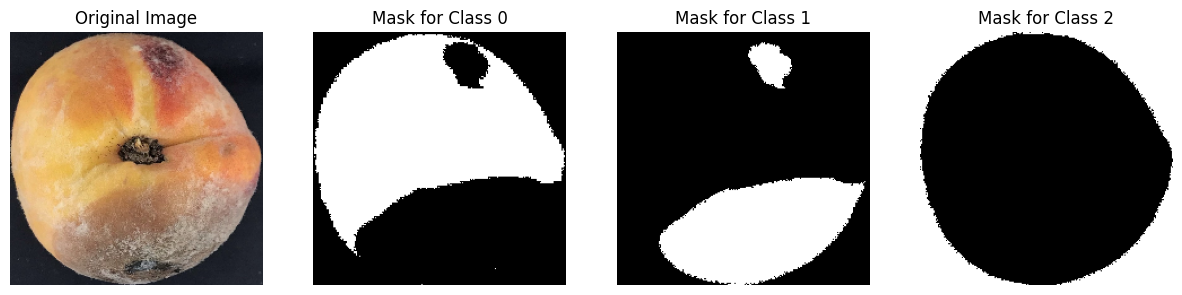

In [169]:
image, masks = train_dataset[3]

print(image.shape, masks.shape)

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot the original image
axes[0].imshow(image.permute(1, 2, 0).numpy() / 255.0)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Plot the first mask (for class 0)
axes[1].imshow(masks[0], cmap="gray")
axes[1].set_title("Mask for Class 0")
axes[1].axis("off")

# Plot the second mask (for class 1)
axes[2].imshow(masks[1], cmap="gray")
axes[2].set_title("Mask for Class 1")
axes[2].axis("off")


# Plot the second mask (for class 1)
axes[3].imshow(masks[2], cmap="gray")
axes[3].set_title("Mask for Class 2")
axes[3].axis("off")

plt.show()

In [170]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

In [171]:
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

In [172]:
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c + out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

In [173]:
class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        """ Bottleneck """
        self.b = conv_block(512, 1024)
        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)
        """ Classifier """
        self.outputs = nn.Conv2d(64, 3, kernel_size=1, padding=0)

    def forward(self, inputs):
        """Encoder"""
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        """ Bottleneck """
        b = self.b(p4)
        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        """ Classifier """
        outputs = self.outputs(d4)
        return outputs

In [174]:
model = build_unet()
model(torch.tensor(image).unsqueeze(0)).shape

C:\Users\user\AppData\Local\Temp\ipykernel_11144\154087395.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model(torch.tensor(image).unsqueeze(0)).shape


torch.Size([1, 3, 224, 224])

In [175]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [176]:
model_1 = build_unet()
model_1 = model_1.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=5, gamma=0.4, verbose=True
)

# Training loop
num_epochs = 50

# Initialize the counter for consecutive non-decreasing epochs
non_decreasing_epochs = 0
best_val_loss = np.inf

for epoch in range(num_epochs):
    model_1.train()  # Set model in training mode
    for images, masks in tqdm(train_data_loader):
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model_1(images)

        # Calculate the loss
        loss = criterion(outputs, masks)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

    # Evaluate on val set
    model_1.eval()  # Set model in evaluation model
    with torch.no_grad():
        total_loss = 0
        for images, masks in val_data_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model_1(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

        val_loss = total_loss / len(val_data_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], val loss: {val_loss:.4f}")

        # Check if the validation loss has decreased
        if val_loss < best_val_loss:
            non_decreasing_epochs = 0
            best_val_loss = val_loss

        else:
            non_decreasing_epochs += 1

        scheduler.step()

        # Check if training should be stopped
        if non_decreasing_epochs >= 5:
            print("Validation loss has not decreased for 5 epochs. Stopping training.")
            break

# Save the trained model
torch.save(
    model_1.state_dict(), "peach_model_bce.pth"
)

Adjusting learning rate of group 0 to 3.0000e-04.


  0%|          | 0/14 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_11144\58258079.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\user\AppData\Local\Temp\ipykernel_11144\58258079.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32).permute(2, 0, 1)
100%|██████████| 14/14 [00:15<00:00,  1.13s/it]


Epoch [1/50], val loss: 0.8251
Adjusting learning rate of group 0 to 3.0000e-04.


100%|██████████| 14/14 [00:15<00:00,  1.10s/it]


Epoch [2/50], val loss: 0.8272
Adjusting learning rate of group 0 to 3.0000e-04.


100%|██████████| 14/14 [00:15<00:00,  1.10s/it]


Epoch [3/50], val loss: 1.8188
Adjusting learning rate of group 0 to 3.0000e-04.


100%|██████████| 14/14 [00:15<00:00,  1.08s/it]


Epoch [4/50], val loss: 0.4125
Adjusting learning rate of group 0 to 3.0000e-04.


100%|██████████| 14/14 [00:15<00:00,  1.13s/it]


Epoch [5/50], val loss: 0.4399
Adjusting learning rate of group 0 to 1.2000e-04.


100%|██████████| 14/14 [00:18<00:00,  1.29s/it]


Epoch [6/50], val loss: 0.3085
Adjusting learning rate of group 0 to 1.2000e-04.


100%|██████████| 14/14 [00:17<00:00,  1.25s/it]


Epoch [7/50], val loss: 0.3010
Adjusting learning rate of group 0 to 1.2000e-04.


100%|██████████| 14/14 [00:16<00:00,  1.19s/it]


Epoch [8/50], val loss: 0.3144
Adjusting learning rate of group 0 to 1.2000e-04.


100%|██████████| 14/14 [00:16<00:00,  1.21s/it]


Epoch [9/50], val loss: 0.3301
Adjusting learning rate of group 0 to 1.2000e-04.


100%|██████████| 14/14 [00:17<00:00,  1.22s/it]


Epoch [10/50], val loss: 0.2787
Adjusting learning rate of group 0 to 4.8000e-05.


100%|██████████| 14/14 [00:16<00:00,  1.19s/it]


Epoch [11/50], val loss: 0.2872
Adjusting learning rate of group 0 to 4.8000e-05.


100%|██████████| 14/14 [00:16<00:00,  1.17s/it]


Epoch [12/50], val loss: 0.2859
Adjusting learning rate of group 0 to 4.8000e-05.


100%|██████████| 14/14 [00:17<00:00,  1.25s/it]


Epoch [13/50], val loss: 0.2703
Adjusting learning rate of group 0 to 4.8000e-05.


100%|██████████| 14/14 [00:17<00:00,  1.22s/it]


Epoch [14/50], val loss: 0.2446
Adjusting learning rate of group 0 to 4.8000e-05.


100%|██████████| 14/14 [00:16<00:00,  1.17s/it]


Epoch [15/50], val loss: 0.2711
Adjusting learning rate of group 0 to 1.9200e-05.


100%|██████████| 14/14 [00:15<00:00,  1.11s/it]


Epoch [16/50], val loss: 0.2409
Adjusting learning rate of group 0 to 1.9200e-05.


100%|██████████| 14/14 [00:15<00:00,  1.11s/it]


Epoch [17/50], val loss: 0.2490
Adjusting learning rate of group 0 to 1.9200e-05.


100%|██████████| 14/14 [00:15<00:00,  1.09s/it]


Epoch [18/50], val loss: 0.2679
Adjusting learning rate of group 0 to 1.9200e-05.


100%|██████████| 14/14 [00:15<00:00,  1.09s/it]


Epoch [19/50], val loss: 0.2431
Adjusting learning rate of group 0 to 1.9200e-05.


100%|██████████| 14/14 [00:15<00:00,  1.10s/it]


Epoch [20/50], val loss: 0.2177
Adjusting learning rate of group 0 to 7.6800e-06.


100%|██████████| 14/14 [00:15<00:00,  1.10s/it]


Epoch [21/50], val loss: 0.2319
Adjusting learning rate of group 0 to 7.6800e-06.


100%|██████████| 14/14 [00:15<00:00,  1.10s/it]


Epoch [22/50], val loss: 0.2420
Adjusting learning rate of group 0 to 7.6800e-06.


100%|██████████| 14/14 [00:15<00:00,  1.10s/it]


Epoch [23/50], val loss: 0.2214
Adjusting learning rate of group 0 to 7.6800e-06.


100%|██████████| 14/14 [00:15<00:00,  1.11s/it]


Epoch [24/50], val loss: 0.2417
Adjusting learning rate of group 0 to 7.6800e-06.


100%|██████████| 14/14 [00:15<00:00,  1.11s/it]


Epoch [25/50], val loss: 0.2458
Adjusting learning rate of group 0 to 3.0720e-06.
Validation loss has not decreased for 5 epochs. Stopping training.


In [177]:
model_1 = build_unet()

checkpoint_1 = torch.load("peach_model_bce.pth")
model_1.load_state_dict(checkpoint_1)
model_1.to("cpu")

build_unet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2

In [178]:
def decode_segmentation(mask):
    # Get the index of the class with the highest probability for each pixel
    mask_binary = np.argmax(mask, axis=0)

    # Define colors for each class
    class_colors = [
        (255, 0, 0),  # Red for class 1
        (0, 255, 0),  # Green for class 2
        (0, 0, 0),  # Black for no class (background)
    ]

    seg_image = np.zeros(
        (mask_binary.shape[0], mask_binary.shape[1], 3), dtype=np.uint8
    )

    # Assign colors corresponding to the argmax indexes
    for class_idx, color in enumerate(class_colors):
        seg_image[mask_binary == class_idx] = color

    return seg_image

C:\Users\user\AppData\Local\Temp\ipykernel_11144\58258079.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\user\AppData\Local\Temp\ipykernel_11144\58258079.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32).permute(2, 0, 1)


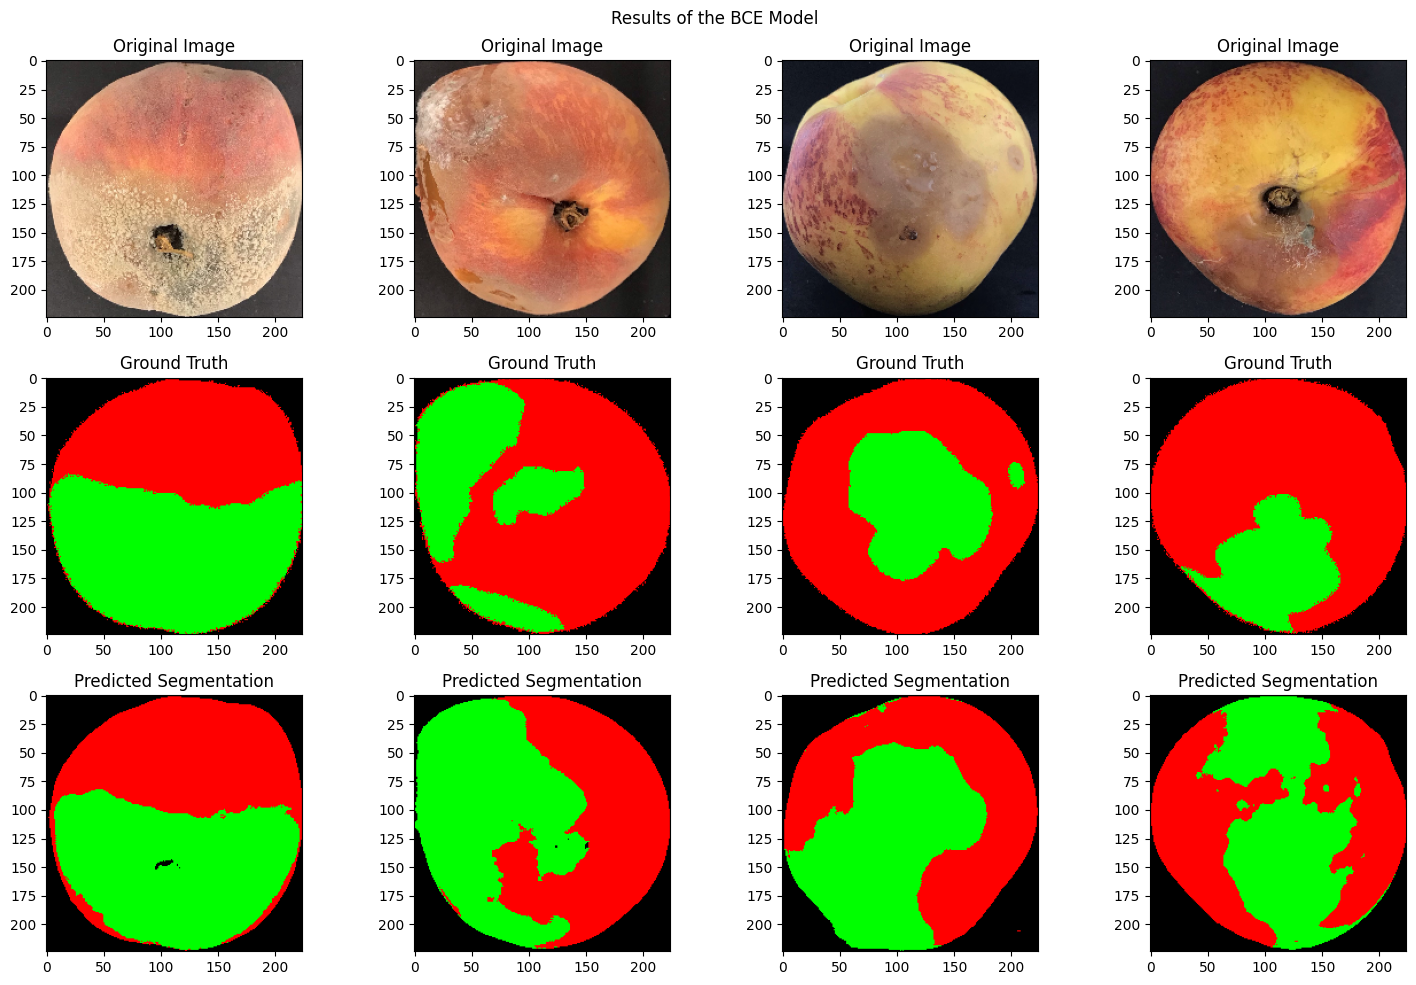

In [188]:
model_1.to("cpu")
idx = np.random.randint(0, len(test_image_paths), 4).astype(int)
fig, ax = plt.subplots(3, 4, figsize=(15, 10))
fig.suptitle("Results of the BCE Model")
cmap = plt.get_cmap("gray")  # Use grayscale colormap

for i, elm in enumerate(idx):
    image, mask = test_dataset[elm]
    preds = torch.softmax(model_1(image.unsqueeze(0)),dim=1)
    
    image = image.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    mask = mask.squeeze().numpy()  # Remove the channel dimension
    preds = preds.detach().squeeze().numpy()

    # Convert multiclass masks and predictions to grayscale images
    mask_gray = decode_segmentation(mask)
    preds_gray = decode_segmentation(preds)

    ax[0, i].set_title("Original Image")
    ax[0, i].imshow(image / 255.0)

    ax[1, i].set_title("Ground Truth")
    ax[1, i].imshow(mask_gray, cmap=cmap)

    ax[2, i].set_title("Predicted Segmentation")
    ax[2, i].imshow(preds_gray, cmap=cmap)

plt.tight_layout()
plt.show()

In [180]:
img = cv2.imread("peach_spoiled.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = test_transform(image=img)
img = torch.tensor(img["image"], dtype=torch.float32)

C:\Users\user\AppData\Local\Temp\ipykernel_11144\2400240595.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img["image"], dtype=torch.float32)


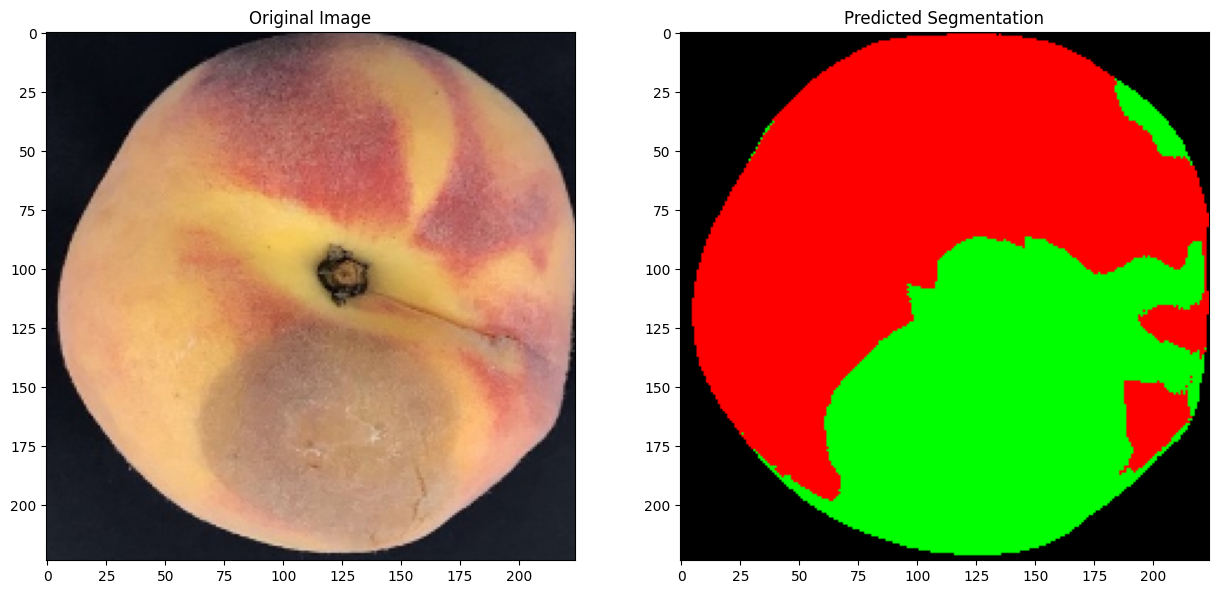

In [181]:
preds = torch.sigmoid(model_1(img.unsqueeze(0)))

preds = preds.detach().squeeze().numpy()


preds_gray = decode_segmentation(preds)

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].set_title("Original Image")
ax[0].imshow(img.permute(1,2,0) / 255.0)


ax[1].set_title("Predicted Segmentation")
ax[1].imshow(preds_gray, cmap=cmap)